## Apache Spark Deep Learning Pipelines 

Proces uczenia modeli w Deep Learning Pipelines opiera się na modelu Apache Spark ML Pipelines. Wykorzystywana jest struktura danych Spark DataFrames i Spark SQL do wdrażania wyuczonych modeli. DLP zawiera wysokopoziomowe interfejsy API dla typowych zadań realizowanych w trakcie tworzenia modeli za pomocą głębokiego uczenia. Dzięki DLP API można efektywnie wykonywać w kilku liniach kodu:
-	ładowanie obrazów, 
-	stosowanie wstępnie wyuczonych modeli jako transformatorów w potoku Spark ML (Transfer learning)
-	stosowanie modeli głębokiego uczenia w skali 
-	rozproszone dostrajanie hiperparametrów modeli
-	wdrażanie modeli za pomocą Spark SQL

Najnowszą wersją biblioteki *spark-deep-learnig* dostępną w trakcie tworzenia eksperymentu jest to 1.5 dla Apache Spark w wersji 2.4.2. I taka wersja zostanie załadowana.

In [1]:
import os
SUBMIT_ARGS = "--packages databricks:spark-deep-learning:1.5.0-spark2.4-s_2.11 --conf spark.driver.extraClassPath=$JAR_PATH --conf spark.executor.extraClassPath=$JAR_PATH pyspark-shell"
os.environ["PYSPARK_SUBMIT_ARGS"] = SUBMIT_ARGS

W przypadku DataBricks załadowanie biblioteki jest czynnością, nie wymagającą poniższych ustawień. Ustawienia wskazują na katalog zawierający pakiety java.
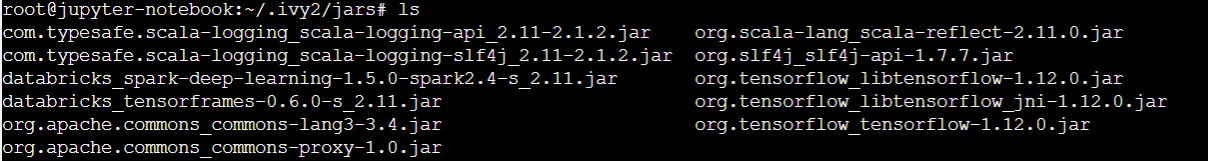

In [2]:
import sys, glob, os
sys.path.extend(glob.glob(os.path.join(os.path.expanduser("~"), ".ivy2/jars/*.jar")))

Stworzenie kontekstu Spark

In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("DL with Spark Deep Cognition").getOrCreate()
sc = spark.sparkContext

Po załadowaniu biblioteki *sparkdl* dowiadujemy się, że korzyta ona z biblioteki TensorFlow. Jest tutaj pewien trik ukryty, związany z wersją języka Python, stosowaną w Apache Sprak. Ważne jest, aby przy tworzeniu środowiska korzystać z wersji najwyżej 3.6. Wersja 3.7 pomimo, że jest już wersją oficjalnie dostęną, jednak najniższą wersją TensorFlow jest 1.13. To znowu wyklucza zastosowanie *sparkdl* w wersji 1.5, która wymaga TensorFlow 1.12 ;) 

In [4]:
import sparkdl

Using TensorFlow backend.


In [5]:
sc.pythonVer

'3.6'

In [6]:
import IPython.display as dp

## Ładowanie obrazów

Pierwszym krokiem do zastosowania głębokiego uczenia się na obrazach jest możliwość ich załadowania. Deep Learning Pipelines zawiera funkcje użytkowe, które mogą załadować miliony obrazów do obiektu DataFrame i zdekodować je automatycznie w  rozproszony sposób, co umożliwia skalowalność manipulację nimi. Spark od wersji 2.3.0 ma wbudowaną tą możliwość, ale w tym przykładzie będziemy używać biblioteki *sparkdl*.

Projekt opiera się na jednym z przewodników do biblioteki TensorFlow (https://www.tensorflow.org/hub/tutorials/image_retraining) i na zbiorze danych w postaci zdjęć kawitów. W pierwszym kroku wybrano trzy zdjęcia jako przykłady do weryfikacji danych.

In [7]:
!cp flower_photos/daisy/100080576_f52e8ee070_n.jpg flower_photos/sample/
!cp flower_photos/daisy/10140303196_b88d3d6cec.jpg flower_photos/sample/
!cp flower_photos/tulips/100930342_92e8746431_n.jpg flower_photos/sample/

In [8]:
# zbierz wszytki obrazy .jpg z obeznego katalogu roboczego
fs = !ls flower_photos/sample/*.jpg

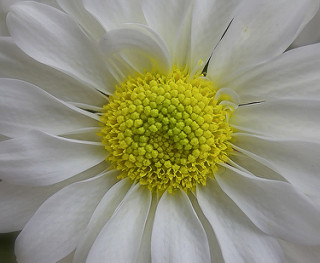

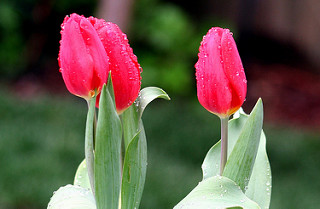

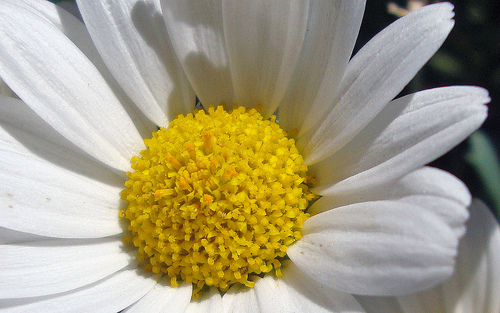

In [9]:
# utwórz listę zdjęć
images = []
for ea in fs:
    images.append(dp.Image(filename=ea, format='png'))

# wyświetl wszystkie obrazy
for ea in images:
    dp.display_png(ea)

Metoda spark.readImage umożliwia wczytywanie obrazów w popularnych formatach (jpg, png itp.) z HDFS do DataFrame. Każdy obraz jest przechowywany jako wiersz w formacie imageSchema. Opcja rekurencyjna umożliwia odczyt obrazów z podfolderów, na przykład dla próbek z etykietą dodatnią i ujemną. Parametr sampleRatio umożliwia eksperymentowanie z mniejszą próbką obrazów przed treningiem modelu z pełnymi danymi.

In [10]:
from pyspark.ml.image import ImageSchema
# wczytaj obrazy korzystając z bibliotek Sparka
image_df = ImageSchema.readImages("./flower_photos/sample/")

In [11]:
image_df.show()

+--------------------+
|               image|
+--------------------+
|[file:/mnt/notebo...|
|[file:/mnt/notebo...|
|[file:/mnt/notebo...|
+--------------------+



In [12]:
from pyspark.ml.image import ImageSchema
from pyspark.sql.functions import lit #utworzenie kolumny z określoną wartością

In [13]:
try:
    from sparkdl.image import imageIO
except Exception as e:
    print(e)

In [14]:
#załadowanie zdjęć za pomocą funkcji Sparka
tulips_df = ImageSchema.readImages("flower_photos/tulips").withColumn("label", lit(1)) #kolumna label z wartością 1

#załadowanie zdjęć za pomocą dunkcji biblioteki sparkdl
daisy_df = imageIO.readImagesWithCustomFn("flower_photos/daisy", decode_f=imageIO.PIL_decode).withColumn("label", lit(0)) 
# label 0

# w przypadku środowiska produkcyjnego używaj większych zestawów uczących/testowych (np. [0.6, 0.4])
tulips_train, tulips_test, _ = tulips_df.randomSplit([0.1, 0.05, 0.85]) #to wersja na prezentację, to nie jest naprawdę ;)

# w przypadku środowiska produkcyjnego używaj większych zestawów uczących/testowych (np. [0.6, 0.4])
daisy_train, daisy_test, _ = daisy_df.randomSplit([0.1, 0.05, 0.85])    

train_df = tulips_train.unionAll(daisy_train)
test_df = tulips_test.unionAll(daisy_test)

# Pod maską, każda z partycji jest załadowana do pamięci, co może być kosztowne.
# Gwarantuje to, że każda z partycji ma mały rozmiar.
train_df = train_df.repartition(100)
test_df = test_df.repartition(100)

In [15]:
tulips_df.count()

799

In [16]:
daisy_df.count()

633

In [17]:
train_df.toPandas().count()

image    138
label    138
dtype: int64

In [18]:
test_df.toPandas().count()

image    75
label    75
dtype: int64

In [65]:
test_df.toPandas().head(10)

,image,label
0,(file:/mnt/notebooks/sqlday2019/flower_photos/...,1
1,(file:/mnt/notebooks/sqlday2019/flower_photos/...,1
2,(file:/mnt/notebooks/sqlday2019/flower_photos/...,1
3,(file:/mnt/notebooks/sqlday2019/flower_photos/...,1
4,(file:/mnt/notebooks/sqlday2019/flower_photos/...,1
5,(file:/mnt/notebooks/sqlday2019/flower_photos/...,1
6,(file:/mnt/notebooks/sqlday2019/flower_photos/...,1
7,(file:/mnt/notebooks/sqlday2019/flower_photos/...,0
8,(file:/mnt/notebooks/sqlday2019/flower_photos/...,0
9,(file:/mnt/notebooks/sqlday2019/flower_photos/...,0


## Zastosowanie metody Transfer Learning

Deep Learning Pipelines posiada narzędzia umożliwiające wykorzystanie ucześniej przetrenowanych modeli, co jest jednym z najszybszych (z punktu widzenia ilości kodu i poświęconemu czasowi na stworzenie nowego modelu) sposobów rozpoczęcia głębokiego uczenia. Używając Deep Learning Pipelines, można wykorzystać wcześniej wytrenowany model w kilku liniach kodu. 

Deep Learning Pipelines umożliwia transfer wiedzy dzięki klase Featurizer. Klasa wykorzystana w przykładzie *Deep image featurizer* wykorzystuje informacje dostarczone przez wskazany model analizy obrazu w celu wdrożenia ich do grafu TensorFlow.

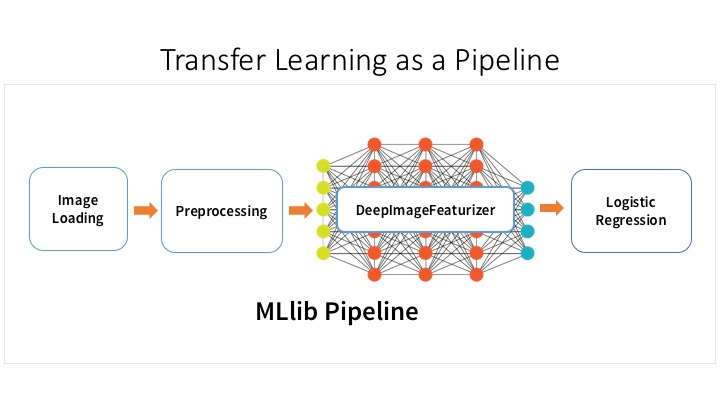

In [19]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline

Klasa *DeepImageFeaturizer* pozwala na zastosowanie pretrenowanego modelu, który określony jest przez jego popularną nazwę (**modelName**) https://github.com/fchollet/deep-learning-models:
- VGG16
- VGG19
- ResNet50
- Inception v3

Z warstwą prognozowania ograniczoną do kolumny obrazu w obiekcie DataFrame (**inputCol**, typ ImageSchema.columnSchema). Wyjściem (**outputCol**) jest obiekt typu MLlib Vector, dzięki czemu DeepImageFeaturizer może być używany w potoku (Pipeline MLlib). Wejściową kolumną obrazów powinna być obiektem ImageSchema.

In [20]:
from sparkdl import DeepImageFeaturizer

Poniższy przykład łączy model InceptionV3 i regresję logistyczną w instancji Spark, przez co można dostosować InceptionV3 do rozwiązania zagadnień wybranej domeny.

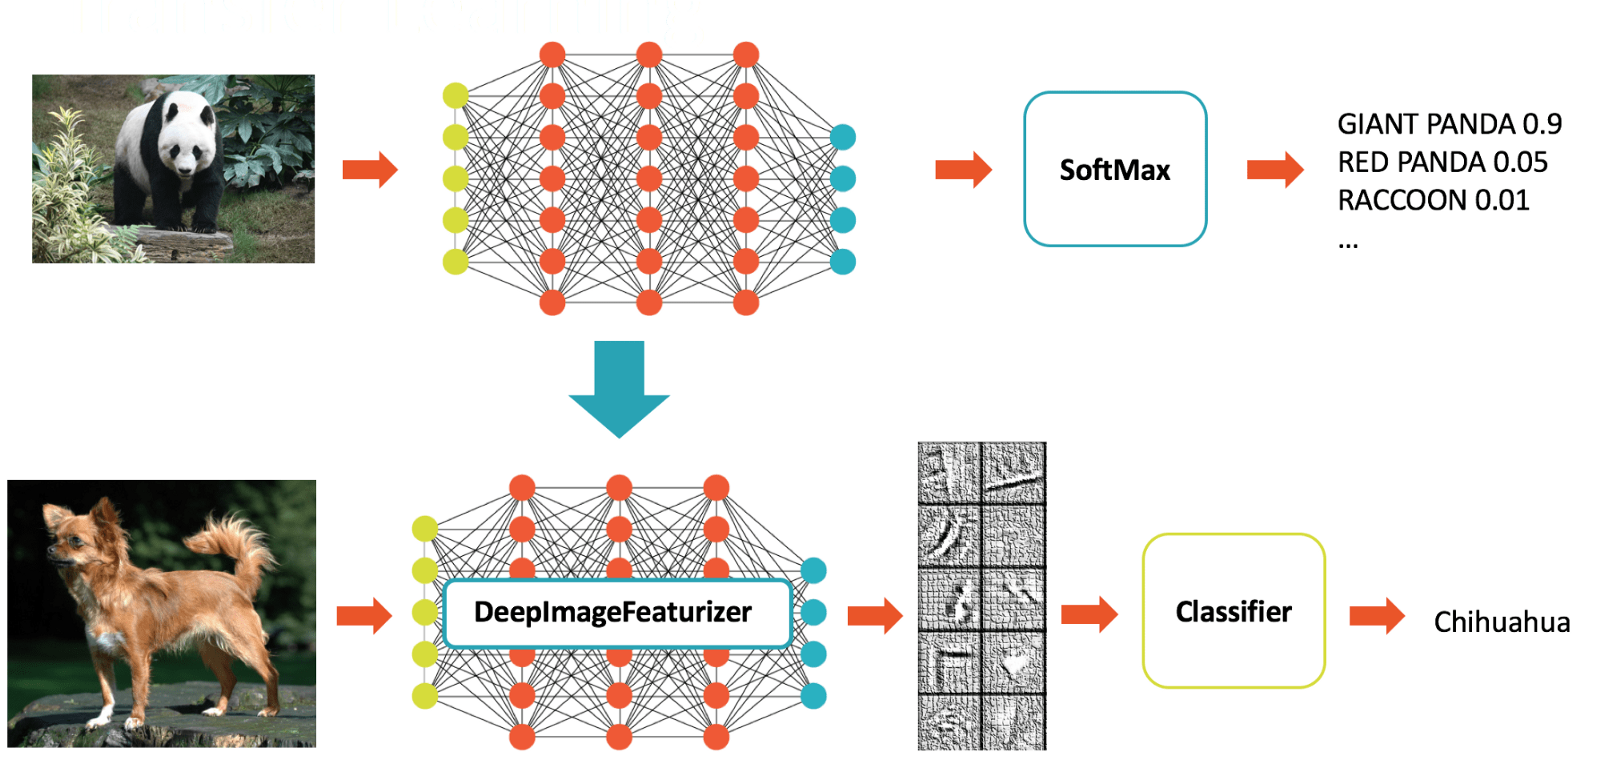

In [21]:
featurizer = DeepImageFeaturizer(inputCol="image", outputCol="features", modelName="InceptionV3")

Start procesu uczenia, z zastosowaniem potoku składającego się z dwóch etapów featurizer (stosującego transfer wiedzy) i regresji liniowej (działającej jako klasyfikator).

In [22]:
lr = LogisticRegression(maxIter=10, regParam=0.05, elasticNetParam=0.3, labelCol="label")
p = Pipeline(stages=[featurizer, lr])

p_model = p.fit(train_df)

Po wytrenowaniu modelu, należy określić jako dobry lub zły jest nowy model.

In [23]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [24]:
tested_df = p_model.transform(test_df)

In [25]:
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
print("Określona dokładność modelu na zbiorze testowym = " + str(evaluator.evaluate(tested_df.select("prediction", "label"))))

Określona dokładność modelu na zbiorze testowym = 0.9733333333333334


Możemy przyjrzeć się, gdzie popełniamy błędy:

In [26]:
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import expr
from pyspark.sql.functions import *
from pyspark.sql.types import *

def _p1(v):
    return float(v.array[1])
take_one = udf(_p1, DoubleType())

df = tested_df.withColumn("p", take_one(tested_df.probability))
wrong_df = df.orderBy(expr("abs(p - label)"), ascending=False)
wrong_df.select("image.origin", "p", "label").show(10)

+--------------------+-------------------+-----+
|              origin|                  p|label|
+--------------------+-------------------+-----+
|file:/mnt/noteboo...| 0.7058213049189761|    0|
|file:/mnt/noteboo...| 0.5825628295566387|    0|
|file:/mnt/noteboo...|0.48304453520224067|    0|
|file:/mnt/noteboo...|  0.595107271524813|    1|
|file:/mnt/noteboo...| 0.3574595407573798|    0|
|file:/mnt/noteboo...|  0.694633856455534|    1|
|file:/mnt/noteboo...| 0.7092609961193049|    1|
|file:/mnt/noteboo...| 0.7363408866840722|    1|
|file:/mnt/noteboo...| 0.7492175672599913|    1|
|file:/mnt/noteboo...|  0.758025908949122|    1|
+--------------------+-------------------+-----+
only showing top 10 rows



Zastosowanie modeli głębokiego uczenia na "większą" skalę 

https://github.com/fchollet/deep-learning-models/releases/

Deep Learning Pipelines daje możliwość uruchamiania wstępnie przygotowanych modeli w sposób rozproszony za pomocą Sparka. Modele mogą być stosowane zarówno w przetwarzaniu wsadowym, jak i strumieniowym. Pozwala korzystać z najbardziej popularnych modeli, umożliwiając użytkownikom korzystanie z modeli głębokiego uczenia bez kosztownego etapu uczenia modelu. Predykcje wykonywane przez model odbywają się równolegle. Oprócz korzystania z wbudowanych modeli, użytkownicy mogą podłączyć modele Keras i TensorFlow Graphs w potoku przewidywania Sparka. Zmienia to modele, które nie dają się zrónoleglić, na takie, które można zastosować w sposób rozproszony na dużej ilości danych. 

Poniższy kod tworzy potok predykcji Sparka przy użyciu modelu InceptionV3, najnowocześniejszego modelu splotowej sieci neuronowej (CNN) do klasyfikacji obrazu i daje predykcje, jakie obiekty znajdują się na obrazach, które właśnie zostały załadowane.

In [27]:
from sparkdl import DeepImagePredictor
# wczytanie zestawu obrazów z zastosowaniem Sparka
image_df = ImageSchema.readImages("flower_photos/sample/")

Na koniec przekazywany jest zbiór danych Sparka zawierający obrazy (image_df) do obiektu sparkdla DeepImagePredictor, który zastosuje określoną (argument *modelName*) wstępnie przygotowaną sieć neuronową do obrazów w celu sklasyfikowania znalezionych obiektów. W naszym przypadku będziemy używać modelu głębokiej sieci neuronowej Inception-v3. Informujemy również DeepImagePredictor, aby zwrócił 10 najlepszych (topK = 10) przewidywanych klasyfikacji dla każdego obrazu w porządku malejącym.

In [28]:
predictor = DeepImagePredictor(inputCol="image", 
                               outputCol="predicted_labels", 
                               modelName="InceptionV3", 
                               decodePredictions=True, 
                               topK=10)
predictions_df = predictor.transform(image_df)

INFO:tensorflow:Froze 378 variables.
INFO:tensorflow:Converted 378 variables to const ops.
INFO:tensorflow:Froze 0 variables.
INFO:tensorflow:Converted 0 variables to const ops.


In [29]:
predictions_df.select("predicted_labels").show(truncate=False,n=3)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|predicted_labels                                                                                                                                                                                                                                                                                                                                                          |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Pierwsza przewidywana etykieta...

In [30]:
predictions_df.select(['predicted_labels']).toPandas().iloc[0].tolist()

[[Row(class='n11939491', description='daisy', probability=0.8918142318725586),
  Row(class='n02219486', description='ant', probability=0.0012404542649164796),
  Row(class='n02206856', description='bee', probability=0.0008130482747219503),
  Row(class='n02190166', description='fly', probability=0.0006038046558387578),
  Row(class='n02165456', description='ladybug', probability=0.0006005447939969599),
  Row(class='n02281406', description='sulphur_butterfly', probability=0.0005320975906215608),
  Row(class='n04599235', description='wool', probability=0.00046653710887767375),
  Row(class='n02112018', description='Pomeranian', probability=0.00046253451728262007),
  Row(class='n07930864', description='cup', probability=0.0004400619654916227),
  Row(class='n02177972', description='weevil', probability=0.0004243419098202139)]]

Zauważ, że kolumna predicted_labels pokazuje „stokrotkę” jako klasę wysokiego prawdopodobieństwa dla wszystkich przykładowych kwiatów przy użyciu tego modelu bazowego, z jakiegoś powodu tulipan był bliżej ogrodzenia pikietowego niż kwiatu (może z powodu tła zdjęcia).

Jednak, jak wynika z różnic w wartościach prawdopodobieństwa, sieć neuronowa ma informacje pozwalające rozpoznać dwa typy kwiatów. W związku z tym nasz powyższy przykład uczenia się transferu był w stanie prawidłowo poznać różnice między stokrotkami i tulipanami, począwszy od modelu podstawowego.

Jak dobrze model rozpoznaje rodzaj kwiatu:

In [31]:
df = p_model.transform(image_df)

In [32]:
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [33]:
def _p1(v):
    return float(v.array[1])
take_one = udf(_p1, DoubleType())

In [34]:
# 100930342_92e8746431_n.jpg nie jest stokotką lecz tulipanem
df.select("image.origin",(1-take_one(df.probability)).alias("p_daisy")).show(truncate=False)

+------------------------------------------------------------------------------+------------------+
|origin                                                                        |p_daisy           |
+------------------------------------------------------------------------------+------------------+
|file:/mnt/notebooks/sqlday2019/flower_photos/sample/100080576_f52e8ee070_n.jpg|0.9671821882228586|
|file:/mnt/notebooks/sqlday2019/flower_photos/sample/100930342_92e8746431_n.jpg|0.076945879530542 |
|file:/mnt/notebooks/sqlday2019/flower_photos/sample/10140303196_b88d3d6cec.jpg|0.9660083082852114|
+------------------------------------------------------------------------------+------------------+



## Zastosowanie biblioteki Keras

Aby zastosować modele Keras w sposób rozproszony za pomocą instancji Spark, klasa KerasImageFileTransformer biblioteki sparkdl wykorzystuje zaplecze udostępniane przez bibliotekę TensorFlow. Proces przeprowadzany jest w następujący sposób:

-	wewnętrznie tworzy obiekt typu DataFrame z kolumną zawierającą obrazy, do czego stosuje określoną przez użytkownika funkcję ładowania i przetwarzania obrazów z wejściowej ramki DataFrame zawierającej kolumnę identyfikatorów URI obrazu
-	ładuje model Keras z podanej ścieżki pliku modelu 
-	aplikuje model do obiektu DataFrame zawiarającego obrazy

Aby użyć transformatora, należy najpierw zapisać model Keras jako plik. W przypadku tego przykładu po prostu należy zapisać wbudowany w bibliotekę Keras model InceptionV3 zamiast go szkolić.

In [35]:
from keras.applications import InceptionV3

model = InceptionV3(weights="imagenet")
model.save('model-full.h5')  # zapis modelu w lokalnym systemie plików

Teraz należy utworzyć transformator Keras, ale najpierw istnieje potrzeba wstępnego przetworzenia obrazów, aby nadawały się one do dalszego przetwarzania.

In [36]:
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.image import img_to_array, load_img
import numpy as np
from pyspark.sql.types import StringType
from sparkdl import KerasImageFileTransformer

Typowy sposób ładowania i przygotowywania obrazów w bibliotece Keras

In [37]:
def loadAndPreprocessKerasInceptionV3(uri):
    image = img_to_array(load_img(uri, target_size=(299, 299)))  # zamiana rozdzielczości dla modelu InceptionV3
    image = np.expand_dims(image, axis=0)
    return preprocess_input(image)

In [38]:
transformer = KerasImageFileTransformer(inputCol="uri", outputCol="predictions",
                                        modelFile='model-full.h5',  # ścieżka do lokalnie zapisanego modelu
                                        imageLoader=loadAndPreprocessKerasInceptionV3,
                                        outputMode="vector")

In [39]:
fs = !ls flower_photos/sample/*.jpg

In [40]:
fs

['flower_photos/sample/100080576_f52e8ee070_n.jpg',
 'flower_photos/sample/100930342_92e8746431_n.jpg',
 'flower_photos/sample/10140303196_b88d3d6cec.jpg']

In [41]:
uri_df = spark.createDataFrame(fs, StringType()).toDF("uri")

In [42]:
uri_df.show()

+--------------------+
|                 uri|
+--------------------+
|flower_photos/sam...|
|flower_photos/sam...|
|flower_photos/sam...|
+--------------------+



In [43]:
keras_pred_df = transformer.transform(uri_df)

/opt/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


INFO:tensorflow:Froze 378 variables.
INFO:tensorflow:Converted 378 variables to const ops.
INFO:tensorflow:Froze 0 variables.
INFO:tensorflow:Converted 0 variables to const ops.


In [44]:
keras_pred_df.select("uri", "predictions").show()

+--------------------+--------------------+
|                 uri|         predictions|
+--------------------+--------------------+
|flower_photos/sam...|[7.43818964110687...|
|flower_photos/sam...|[3.56565986294299...|
|flower_photos/sam...|[3.49412512150593...|
+--------------------+--------------------+



In [45]:
df_keras = keras_pred_df.select("uri", "predictions").toPandas()

In [46]:
df_keras

,uri,predictions
0,flower_photos/sample/100080576_f52e8ee070_n.jpg,"[7.438189641106874e-05, 7.319115684367716e-05,..."
1,flower_photos/sample/100930342_92e8746431_n.jpg,"[0.00035656598629429936, 0.003536983160302043,..."
2,flower_photos/sample/10140303196_b88d3d6cec.jpg,"[3.494125121505931e-05, 5.081537165096961e-05,..."


In [47]:
from keras.applications.inception_v3 import decode_predictions

In [48]:
#print('Predicted:', decode_predictions(feat_array, top=10))

## Wykorzystanie struktury tensorów

Deep Learning Pipelines zapewnia również możliwość zastosowania modeli w połączeniu z danymi wejściowymi w postaci dwuwymiarowych tensorów. Modele mogą być trenowane za pomocą popularnych bibliotek do głębokiego uczenia: 
- TensorFlow  
- Keras

Przykład dalej zamieszczony skupiaja się na zastosowaniu modeli Keras. Klasa KerasTransformer stosuje model Keras oparty na TensorFlow na danych wejściowych, jak już wspomniano wcześniej, które są reprezentowane przez maksymalnie dwuwymiarowy tensor. W konstruktorze klasy, argument **modelFile** wskazuje na ścieżkę, gdzie zapisany jest model. Następnie podawane są argumenty **inputCol** wskazuje na kolumne zawierającą macierze (gdzie każda macierz odpowiada tensorowi), **outputCol** także wskazujący na kolumnę zawierającą macierze.

In [49]:
from sparkdl import KerasTransformer
from keras.models import Sequential
from keras.layers import Dense
import numpy as np

In [50]:
# Generowanie losowych danych wejściowych
num_features = 10
num_examples = 100
input_data = [{"features" : np.random.randn(num_features).astype(float).tolist()} for i in range(num_examples)]
schema = StructType([ StructField("features", ArrayType(FloatType()), True)])
input_df = spark.createDataFrame(input_data, schema)

In [51]:
input_df.toPandas().iloc[0].tolist()

[[-0.12440650910139084,
  1.1935198307037354,
  -0.014985023997724056,
  0.4470153748989105,
  0.8132008910179138,
  -2.317117691040039,
  -1.2503165006637573,
  0.09705674648284912,
  0.3410077691078186,
  0.018191425129771233]]

In [52]:
# Utworzenie i zapis modelu Keras z pojedynczą warstwą ukrytą służącego do klasyfikacji binarnej. 
# UWAGA: W typowym przepływie pracy na wstępie należy wytrenować model przed eksportowaniem go na dysk, 
# ale w przykładzie pominięty zostanie ten krok dla zachowania zwięzłości przykładu

model = Sequential()

# Typ modelu, którego będziemy używać, to Sekwencyjny. Sekwencyjny to najprostszy sposób na zbudowanie modelu w Keras. 
# Pozwala budować model warstwa po warstwie. Każda warstwa ma wagi, które odpowiadają warstwie, po której następuje.

# "Dense" to rodzaj warstwy. Warstwa Gęsta jest standardowym typem warstwy, który działa w większości przypadków. 
# W gęstej warstwie wszystkie węzły w poprzedniej warstwie łączą się z węzłami w bieżącej warstwie.

# W warstwie ukrytej znajduje się 20 neuronów, w warstwie wyjściowej jeden.
# activation to funkcja aktywacji warstwy. Funkcja aktywacji umożliwia modelom uwzględnienie relacji nieliniowych.
# Funkcją aktywacji, która będzie używana to ReLU lub Rectified Linear Activation. 
# Chociaż jest to funkcja składająca się z dwu elementów liniowych, 
# udowodniono, że działa dobrze w sieciach neuronowych.

model.add(Dense(units=20, input_shape=[num_features], activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

# Zapis modelu na dysku
model_path = "simple-binary-classification"
model.save(model_path)

In [53]:
# Tworzenie instancji obiektu transformer a następnie zastosowanie go do danych wejściowych
# Odczytanie wcześniej zapisanego modelu.

transformer = KerasTransformer(inputCol="features", outputCol="predictions", modelFile=model_path)
final_df = transformer.transform(input_df)

INFO:tensorflow:Froze 4 variables.
INFO:tensorflow:Converted 4 variables to const ops.
INFO:tensorflow:Froze 0 variables.
INFO:tensorflow:Converted 0 variables to const ops.


In [54]:
final_df.limit(20).toPandas()

,predictions,features
0,[0.6443734169006348],"[-0.12440650910139084, 1.1935198307037354, -0...."
1,[0.6262466311454773],"[-0.034665562212467194, 0.4050900340080261, -0..."
2,[0.6154974699020386],"[-0.912808895111084, 0.4894823729991913, 0.305..."
3,[0.5187386870384216],"[-0.20153729617595673, 1.1403685808181763, -1...."
4,[0.5085059404373169],"[-0.10403081029653549, -0.673218846321106, 0.9..."
5,[0.3448256552219391],"[1.3805029392242432, 0.20859934389591217, -0.3..."
6,[0.5896320343017578],"[-0.3668104410171509, 1.9942265748977661, 0.04..."
7,[0.4213489592075348],"[0.9025575518608093, 0.2252744436264038, -0.31..."
8,[0.5380851626396179],"[0.4938109219074249, 1.6179622411727905, 0.768..."
9,[0.3258909583091736],"[0.45833611488342285, -0.1469331830739975, 1.2..."


## Wdrażanie modeli za pomocą SQL

Jednym ze sposobów wdrażania modelu do produkcji, jest wdrożenie za pomocą mechanizmu Spark SQL User Defined Function. Deep Learning Pipelines zawiera mechanizmy i narzędzia do zastosowania modeli głębokiego uczenia modelu w procesie tworzenia Spark SQL User Defined Function (UDF). 

*registerKerasImageUDF* tworzy funkcję użytkownika (UDF SQL Spark) wskazującą model Keras służący do przetwarzania obrazów. UDF pobiera kolumnę (sformatowaną jako sparkdl.image.imageIO.imageSchema) i generuje dane wyjściowe za pomocą wybranego modelu Keras (np. w przypadku modelu Inception V3 tworzony jest wektor wartości rzeczywistych odnoszących się do kategorii obiektów modelu ImageNet). W przypadku innych modeli dane wyjściowe mogą mieć różne znaczenia, dlatego aby zrozumieć znaczenie wyników należy sprawdzić specyfikację modeli.

In [55]:
from keras.applications import InceptionV3
from sparkdl.udf.keras_image_model import registerKerasImageUDF

registerKerasImageUDF("inceptionV3_udf", InceptionV3(weights="imagenet"))

INFO:tensorflow:Froze 0 variables.
INFO:tensorflow:Converted 0 variables to const ops.
INFO:tensorflow:Froze 378 variables.
INFO:tensorflow:Converted 378 variables to const ops.
INFO:tensorflow:Froze 0 variables.
INFO:tensorflow:Converted 0 variables to const ops.
INFO:tensorflow:Froze 0 variables.
INFO:tensorflow:Converted 0 variables to const ops.


Przepływ pracy związanego z anazlizą obazów z biblioteką Keras, często stosuje się etapy przetwarzania wstępnego przed zastosowaniem modelu do obrazu. Jeśli przepływ pracy wymaga przetwarzania wstępnego, możemy opcjonalnie udostępnić funkcję przetwarzania wstępnego rejestracji UDF. Preprocesor powinien przyjąć ścieżkę do pliku i zwrócić tablicę obrazów.

In [56]:
from keras.applications import InceptionV3
from sparkdl.udf.keras_image_model import registerKerasImageUDF

In [57]:
def keras_load_img(fpath):
    from keras.preprocessing.image import load_img, img_to_array
    import numpy as np
    img = load_img(fpath, target_size=(299, 299))
    return img_to_array(img).astype(np.uint8)

In [58]:
registerKerasImageUDF("inceptionV3_udf_with_preprocessing", InceptionV3(weights="imagenet"), keras_load_img)

INFO:tensorflow:Froze 0 variables.
INFO:tensorflow:Converted 0 variables to const ops.
INFO:tensorflow:Froze 378 variables.
INFO:tensorflow:Converted 378 variables to const ops.
INFO:tensorflow:Froze 0 variables.
INFO:tensorflow:Converted 0 variables to const ops.
INFO:tensorflow:Froze 0 variables.
INFO:tensorflow:Converted 0 variables to const ops.


Po zarejestrowaniu UDF można ją użyć w zapytaniu SQL:

In [59]:
from pyspark.ml.image import ImageSchema

In [60]:
image_df = ImageSchema.readImages("flower_photos/sample/")
image_df.registerTempTable("sample_images")

In [61]:
image_df.show()

+--------------------+
|               image|
+--------------------+
|[file:/mnt/notebo...|
|[file:/mnt/notebo...|
|[file:/mnt/notebo...|
+--------------------+



In [62]:
df_p = spark.sql("SELECT inceptionV3_udf_with_preprocessing(image), image as predictions from sample_images order by predictions asc").toDF('prediction', 'image')
df_pandas = df_p.toPandas()